# Word2Vec then RNN

## Imports and setting up TensorBoard

In [3]:
from data_preparation import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, Dropout, Embedding
from keras.optimizers import Adam
from keras_train_helper import tfauc
from tensorflow.python.client import device_lib
from keras_train_helper import rotateTensorboardLogs
from keras.callbacks import TensorBoard
from keras_train_helper import PrintAucCallback

tensorBoardCallback = TensorBoard(log_dir="./tb-logs")
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5875315600476728809
]


## Loading data and setting up preprocessing tools

In [4]:
train, test, allData, contestTest = loadData()

Loading datasets...
train: (127656, 8), test: (31915, 8), allData: (159571, 8), contestTest: (153164, 2)


In [5]:
from sklearn.pipeline import Pipeline

maxSeqLength = 250

splitter = SentenceSplitter("comment_text")
allWords = pd.concat([splitter.transform(allData), splitter.transform(contestTest)])
w2i = Word2Int(allWords)
zeroPadder = ZeroPadder(maxSeqLength)

preparationPipeline = Pipeline(steps=[
    ("split", splitter),
    ("w2i", w2i),
    ("zeroPadding", zeroPadder) ])

Splitting sentences...
Splitting sentences...
Loading w2i and i2w dictionaries...


In [6]:
w2v = Word2Vec(50, allWords, w2i.w2i, seed=4324)
embeddingMatrix, i2v = w2v.embeddingMatrix()

Loading word2vec dictionary...


## Define the model

### Define the model

In [7]:
lstmUnits = [100]
numClasses = 2
batchSize = 1024

In [8]:
model = Sequential()

model.add(Embedding(
    embeddingMatrix.shape[0],
    embeddingMatrix.shape[1],
    weights=[embeddingMatrix],
    input_length=maxSeqLength,
    trainable=False))

model.add(Bidirectional(LSTM(lstmUnits[0]), name="LSTM"))

model.add(Dropout(.2, name="dropout"))

model.add(Dense(
    2, 
    activation="softmax", 
    name="softmax_output"))

model.compile(
    loss="categorical_crossentropy", 
    optimizer="nadam", 
    metrics=[tfauc])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 50)           19255800  
_________________________________________________________________
LSTM (Bidirectional)         (None, 200)               120800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
softmax_output (Dense)       (None, 2)                 402       
Total params: 19,377,002
Trainable params: 121,202
Non-trainable params: 19,255,800
_________________________________________________________________
None


## Prepare data and train the model

In [9]:
rotateTensorboardLogs()

In [10]:
labelizer = Labelizer("toxic")
oversampler = Oversampler("toxic")

In [11]:
trainOversampled = oversampler.transform(train)

trainSentences = preparationPipeline.transform(trainOversampled)
trainLabels = labelizer.transform(trainOversampled)
testSentences = preparationPipeline.transform(test)
testLabels = labelizer.transform(test)

Oversampling...
Splitting sentences...
Converting words to integers...
Zero-padding...
Splitting sentences...
Converting words to integers...
Zero-padding...


In [ ]:
%%time
tf.set_random_seed(43245)
np.random.seed(453252)
printAucCallback = PrintAucCallback(testSentences, testLabels, allTestDataPerEpochs=1)

model.fit(
    trainSentences, 
    trainLabels, 
    nb_epoch=5, 
    batch_size=batchSize,
    callbacks=[tensorBoardCallback, printAucCallback])

## Evaluate on test data

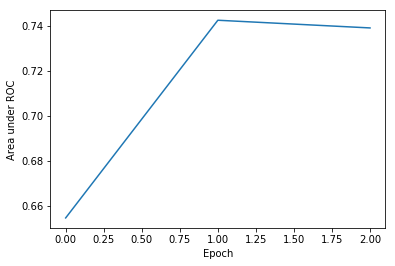

In [20]:
import matplotlib.pyplot as plt
plt.plot([value for key, value in printAucCallback.listOfAucs])

plt.ylabel("Area under ROC")
plt.xlabel("Epoch")
plt.show()

           P Neutral  P Toxic
T Neutral       9016        5
T Toxic          960       19


           P Neutral  P Toxic
T Neutral     0.9016   0.0005
T Toxic       0.0960   0.0019


0.038


0.2818


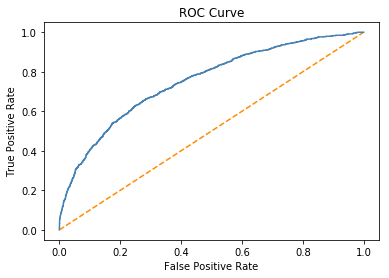

In [21]:
from evaluate_predictions import evaluatePredictions

predictions = model.predict(testSentences, batch_size=batchSize)
binaryPredictions = np.where(predictions[:, 1] > 0.5, 1, 0)
labels = testLabels[:, 1]

evaluatePredictions(pd.Series(labels), binaryPredictions, predictions)